In [2]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical

#Загрузим данные
df_train = pd.read_csv('adult.data', sep =', ')
df_valid = pd.read_csv('adult.test', sep =', ')
print('------------- data loaded -----------')

Using TensorFlow backend.
D:\soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
D:\soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


------------- data loaded -----------


In [3]:
def replace_spaces(arr) :
    for i in range(0, len(arr)):
        el = arr[i]
        if (isinstance(el, str)):
            arr[i] = el.replace(' ', '').replace('.', '').upper()
    return arr

def tranform_dtype(df):
    columns = df.select_dtypes(['object']).columns
    for i in columns:
        df[i] = replace_spaces(df[i].to_numpy())
        df[i] = df[i].astype('category')
    df[columns] = df[columns].apply(lambda x: x.cat.codes)

def tranform_dtype1(df):
    columns = df.select_dtypes(['object']).columns
    for i in columns:
        df[i] = replace_spaces(df[i].to_numpy())
        if len(df.groupby([i]).size()) > 2:
         df = pd.get_dummies(df, prefix=[i], columns=[i])
    return pd.get_dummies(df, drop_first=True)

print('------------Prepare DF binarization -----------------------')
df_valid = tranform_dtype1(df_valid)
df_valid['ctr_HOLAND-NETHERLANDS'] = np.zeros(len(df_valid['ctr_LAOS']))
df_train = tranform_dtype1(df_train)
df_valid = df_valid[df_train.columns]
print(df_valid)

------------Prepare DF binarization -----------------------
       age     wgt  edn   cpg  cpl  hpw  wcl_?  wcl_FEDERAL-GOV  \
0       25  226802    7     0    0   40      0                0   
1       38   89814    9     0    0   50      0                0   
2       28  336951   12     0    0   40      0                0   
3       44  160323   10  7688    0   40      0                0   
4       18  103497   10     0    0   30      1                0   
...    ...     ...  ...   ...  ...  ...    ...              ...   
16276   39  215419   13     0    0   36      0                0   
16277   64  321403    9     0    0   40      1                0   
16278   38  374983   13     0    0   50      0                0   
16279   44   83891   13  5455    0   40      0                0   
16280   35  182148   13     0    0   60      0                0   

       wcl_LOCAL-GOV  wcl_NEVER-WORKED  ...  ctr_SCOTLAND  ctr_SOUTH  \
0                  0                 0  ...             0      

In [4]:
data_valid = df_valid.to_numpy()
data_train = df_train.to_numpy()

train_label = to_categorical(data_train[:, -1])
train_sample = data_train[:, :-1]
train_sample = train_sample.reshape(len(train_sample), train_sample.shape[1], 1)

valid_label = to_categorical(data_valid[:, -1])
valid_sample = data_valid[:,:-1]
valid_sample = valid_sample.reshape(len(valid_sample), valid_sample.shape[1], 1)
print('Train labels shape = ', train_label.shape)
print('Train samples shape = ', train_sample.shape)
print('Validation labels shape = ', valid_label.shape)
print('Validation samples shape = ', valid_sample.shape)


Train labels shape =  (32561, 2)
Train samples shape =  (32561, 107, 1)
Validation labels shape =  (16281, 2)
Validation samples shape =  (16281, 107, 1)


In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

print('------- Prepare Model -----------------')
actv = 'sigmoid'
model = models.Sequential()
model.add(layers.Conv1D(14,6,activation=actv,
                        input_shape=(train_sample.shape[1], 1)))
model.add(layers.MaxPool1D(pool_size=3, strides=(2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32,3,activation=actv))
model.add(layers.MaxPool1D(pool_size=3, strides=(2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.05))
model.add(layers.Conv1D(16,2,activation=actv))
model.add(layers.MaxPool1D(pool_size=3, strides=(2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=actv))
model.add(layers.Dense(64, activation=actv))
model.add(layers.Dense(32, activation=actv))
model.add(layers.Dense(16,  activation=actv))
model.add(layers.Dense(8,  activation=actv))
model.add(layers.Dense(2,  activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x=train_sample,
                    y=train_label,
                    epochs=15,
                    batch_size=128,
                    validation_data = (valid_sample, valid_label)
                    )

------- Prepare Model -----------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 102, 14)           98        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 51, 14)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 51, 14)            56        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 49, 32)            1376      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 32)            128       
_________________________________________________________________
dropout (Dropout

------- Plot losses -----------------


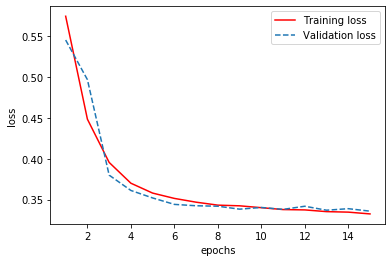

In [6]:
import matplotlib.pyplot as plt
print('------- Plot losses -----------------')
hist_dcit = history.history
loss = hist_dcit['loss']
val_loss = hist_dcit['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b',color='r', label = 'Training loss')
plt.plot(epochs, val_loss, '--', label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

------- Plot acc -----------------


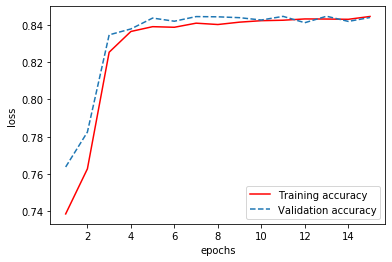

In [7]:
print('------- Plot acc -----------------')
acc = hist_dcit['accuracy']
val_acc = hist_dcit['val_accuracy']
plt.plot(epochs, acc, 'b',color='r',label = 'Training accuracy')
plt.plot(epochs, val_acc, '--', label = 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

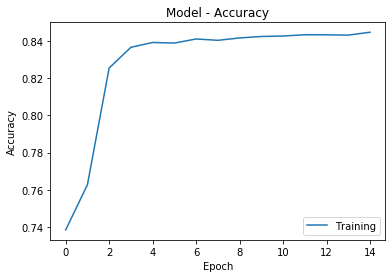

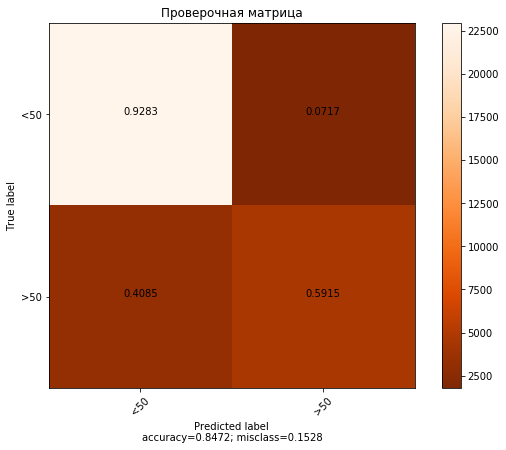

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from lb4.lib import plot_confusion_matrix

y_pred = np.argmax(model.predict(train_sample), axis=1)

cf = confusion_matrix(data_train[:, -1], y_pred)

plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training'], loc='lower right')
plt.show()
plt.close()
np.set_printoptions(precision=2)

title = 'Проверочная матрица'
labels_arr = ['<50', '>50']

plot_confusion_matrix(cf, title = title,
                             target_names = labels_arr,
                             normalize=True,
                                 cmap=plt.cm.Oranges_r)

